<h2 style="color:#1f77b4;">Live Coding Parte 2</h2>

In [24]:
import numpy as np
import pandas as pd

df = pd.read_csv("data/house_eda.csv")
df.head()

,precio_uf,superficie_m2,dormitorios,banos,antiguedad_anios,distancia_centro_km,tipo_vivienda,sector,gasto_comun_uf
0,4947.042738,97.538684,1,3,12.0,10.919752,casa,sur,1.698835
1,4375.562129,89.132206,3,2,39.0,15.123260,casa,norte,1.295728
2,5082.919684,60.783049,4,3,8.0,18.306732,departamento,norte,1.982589
3,5870.726871,118.570570,2,1,26.0,11.910416,casa,norte,1.507754
4,4289.261963,108.798326,1,1,1.0,14.659356,departamento,norte,2.652326


<h5 style="color:#1f77b4;">1. Detecta valores perdidos y aplica técnicas de imputación adecuadas según el tipo de variable.</h5>

In [2]:
# Diagnóstico rápido de nulos
nulos = df.isnull().sum().sort_values(ascending=False)
porc_nulos = (df.isnull().mean() * 100).sort_values(ascending=False)

resumen_nulos = pd.DataFrame({"nulos": nulos, "%": porc_nulos})
resumen_nulos


,nulos,%
gasto_comun_uf,3,2.500000
tipo_vivienda,2,1.666667
antiguedad_anios,1,0.833333
precio_uf,0,0.000000
superficie_m2,0,0.000000
banos,0,0.000000
dormitorios,0,0.000000
distancia_centro_km,0,0.000000
sector,0,0.000000


Imputación (numéricas + categóricas)<br>
* Numéricas: gasto_comun_uf (mediana por tipo vivienda)
* Categóricas: tipo_vivienda (moda),

In [3]:
df_clean = df.copy()

In [4]:
df_clean["gasto_comun_uf"] = df_clean["gasto_comun_uf"].fillna(
    df_clean.groupby("tipo_vivienda")["gasto_comun_uf"].transform("median")
)

In [5]:
df_clean.isnull().sum().sort_values(ascending=False)

tipo_vivienda          2
antiguedad_anios       1
precio_uf              0
dormitorios            0
superficie_m2          0
banos                  0
distancia_centro_km    0
sector                 0
gasto_comun_uf         0
dtype: int64

In [6]:
df_clean[df_clean["tipo_vivienda"].isna()]


,precio_uf,superficie_m2,dormitorios,banos,antiguedad_anios,distancia_centro_km,tipo_vivienda,sector,gasto_comun_uf
6,5921.291534,67.265314,4,3,28.0,7.868086,NaN,sur,0.986907
28,3959.425179,94.615846,1,2,12.0,15.801031,NaN,norte,1.662512


Esta es imputación condicional, no arbitraria.
* departamentos → suelen tener gasto común > 0
* casas → suelen tener gasto común bajo o cercano a 0

In [7]:
# --- CATEGÓRICAS ---
cond = df_clean["tipo_vivienda"].isna()

df_clean.loc[
    cond & (df_clean["gasto_comun_uf"] > 0.5),
    "tipo_vivienda"
] = "departamento"

df_clean.loc[
    cond & (df_clean["gasto_comun_uf"] <= 0.5),
    "tipo_vivienda"
] = "casa"

In [8]:
df_clean.isnull().sum().sort_values(ascending=False)

antiguedad_anios       1
precio_uf              0
superficie_m2          0
dormitorios            0
banos                  0
distancia_centro_km    0
tipo_vivienda          0
sector                 0
gasto_comun_uf         0
dtype: int64

In [9]:
df_clean[df_clean["antiguedad_anios"].isna()]

,precio_uf,superficie_m2,dormitorios,banos,antiguedad_anios,distancia_centro_km,tipo_vivienda,sector,gasto_comun_uf
119,22000.0,520.0,2,1,NaN,0.1,casa,centro,2.343025


In [10]:
df_clean["antiguedad_anios"] = df_clean["antiguedad_anios"].fillna(
    df_clean.groupby("tipo_vivienda")["antiguedad_anios"].transform("median")
)


In [11]:
df_clean.isnull().sum().sort_values(ascending=False)

precio_uf              0
superficie_m2          0
dormitorios            0
banos                  0
antiguedad_anios       0
distancia_centro_km    0
tipo_vivienda          0
sector                 0
gasto_comun_uf         0
dtype: int64

<h5 style="color:#1f77b4;">2. Identificar outliers con al menos dos métodos diferentes (uno estadístico y uno basado en ML).</h5>

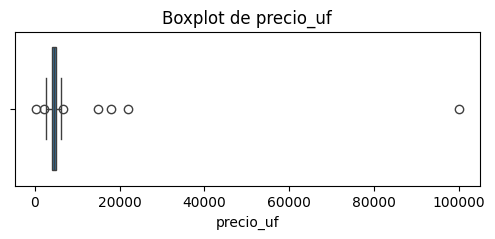

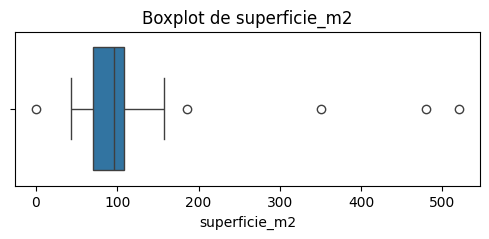

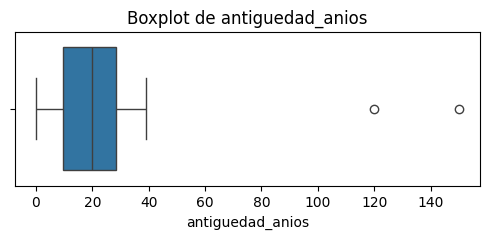

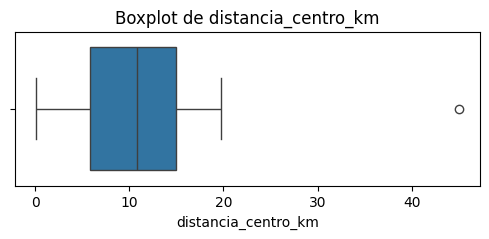

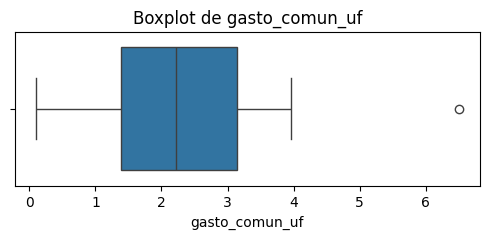

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = [
    "precio_uf",
    "superficie_m2",
    "antiguedad_anios",
    "distancia_centro_km",
    "gasto_comun_uf"
]

for col in num_cols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df_clean[col])
    plt.title(f"Boxplot de {col}")
    plt.show()


2.1 IQR (para Fare)

In [13]:
df_clean.describe()

,precio_uf,superficie_m2,dormitorios,banos,antiguedad_anios,distancia_centro_km,gasto_comun_uf
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,5527.959333,100.063904,2.516667,1.966667,21.175000,10.458421,2.241675
std,9023.818878,63.052083,1.250098,0.978194,18.834379,6.246253,1.064391
min,300.000000,0.000000,1.000000,1.000000,0.000000,0.100000,0.100000
25%,3985.312213,70.215186,1.000000,1.000000,9.750000,5.827731,1.394193
50%,4434.094783,95.519421,2.000000,2.000000,20.000000,10.784963,2.225389
75%,4950.767226,108.087091,4.000000,3.000000,28.250000,14.938930,3.146958
max,99999.000000,520.000000,7.000000,6.000000,150.000000,45.000000,6.500000


In [14]:
df_clean[df_clean["precio_uf"] > 50000]


,precio_uf,superficie_m2,dormitorios,banos,antiguedad_anios,distancia_centro_km,tipo_vivienda,sector,gasto_comun_uf
117,99999.0,60.0,6,5,150.0,7.424534,departamento,sur,6.5


In [15]:
def outliers_iqr(s, k=1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    mask = (s < low) | (s > high)
    return mask, low, high

mask_fare_iqr, low_fare, high_fare = outliers_iqr(df_clean["precio_uf"])
print("Outliers precio_uf (IQR):", mask_fare_iqr.sum())
print("Límites precio_uf:", low_fare, high_fare)


Outliers precio_uf (IQR): 7
Límites precio_uf: 2537.1296927269013 6398.949745536798


In [16]:
df_clean.loc[mask_fare_iqr, [
    "precio_uf",
    "superficie_m2",
    "tipo_vivienda",
    "distancia_centro_km",
    "antiguedad_anios"
]]


,precio_uf,superficie_m2,tipo_vivienda,distancia_centro_km,antiguedad_anios
74,2142.229406,52.128819,casa,10.921258,7.0
113,6716.917901,72.117407,departamento,10.939043,5.0
115,15000.000000,480.000000,casa,7.187074,16.0
116,18000.000000,350.000000,departamento,9.742414,120.0
117,99999.000000,60.000000,departamento,7.424534,150.0
118,300.000000,0.000000,departamento,45.000000,2.0
119,22000.000000,520.000000,casa,0.100000,20.0


Isolation Forest (multivariable)

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

features = [
    "precio_uf",
    "superficie_m2",
    "distancia_centro_km",
    "antiguedad_anios",
    "gasto_comun_uf"
]

X = df_clean[features].copy()


imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_scaled = scaler.fit_transform(imputer.fit_transform(X))

iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
pred = iso.fit_predict(X_scaled)
score = iso.decision_function(X_scaled)

df_clean["outlier_if"] = (pred == -1)
df_clean["if_score"] = score

df_clean["outlier_if"].value_counts()


outlier_if
False    114
True       6
Name: count, dtype: int64

In [18]:
df_clean[df_clean["outlier_if"]][
    ["precio_uf", "superficie_m2", "distancia_centro_km",
     "antiguedad_anios", "tipo_vivienda", "if_score"]
].sort_values("if_score")


,precio_uf,superficie_m2,distancia_centro_km,antiguedad_anios,tipo_vivienda,if_score
117,99999.000000,60.000000,7.424534,150.0,departamento,-0.349760
116,18000.000000,350.000000,9.742414,120.0,departamento,-0.263956
118,300.000000,0.000000,45.000000,2.0,departamento,-0.250480
119,22000.000000,520.000000,0.100000,20.0,casa,-0.222893
115,15000.000000,480.000000,7.187074,16.0,casa,-0.157432
33,3548.060164,103.048539,19.619023,38.0,departamento,-0.003510


<h5 style="color:#1f77b4;">3. Aplica winsorización o transformaciones para reducir el impacto de valores extremos.</h5>

Winsorización en precio_uf

In [19]:
df_wins = df.copy()
from scipy.stats.mstats import winsorize

df_clean["precio_uf_win"] = winsorize(
    df_clean["precio_uf"],
    limits=[0.01, 0.01]  # 1% abajo y arriba
)



In [20]:
df_clean[["precio_uf", "precio_uf_win"]].describe()


,precio_uf,precio_uf_win
count,120.000000,120.000000
mean,5527.959333,4893.319578
std,9023.818878,2858.626400
min,300.000000,2142.229406
25%,3985.312213,3985.312213
50%,4434.094783,4434.094783
75%,4950.767226,4950.767226
max,99999.000000,22000.000000


<Axes: >

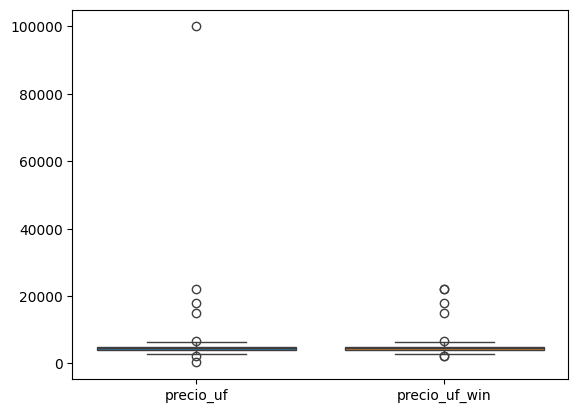

In [21]:
import seaborn as sns
sns.boxplot(data=df_clean[["precio_uf", "precio_uf_win"]])


Transformación log

In [22]:
df_log = df_clean.copy()
df_log["precio_log"] = np.log(df_log["precio_uf"])



<Axes: >

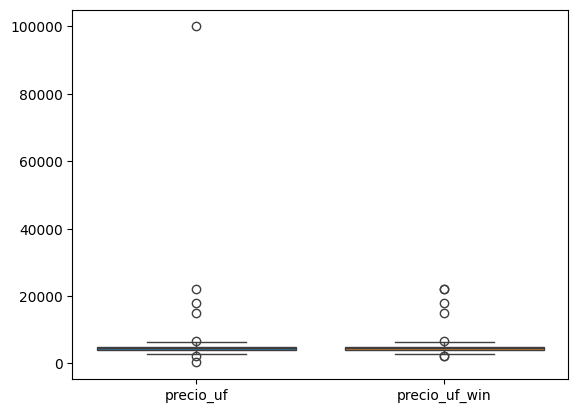

In [23]:
import seaborn as sns
sns.boxplot(data=df_log[["precio_uf", "precio_uf_win"]])

<h5 style="color:#1f77b4;">4. Documenta el flujo y justifica las decisiones tomadas.</h5>

* Diagnostico faltantes y priorizo.
* Imputo numéricas con mediana por segmento (evito sesgos por mezcla de grupos).
* Imputo tipo_vivienda con una regla auditable basada en gasto_comun_uf.
* Detecto outliers univariados (IQR) y los interpreto a nivel de registro (error vs caso legítimo).
* Detecto outliers multivariables (Isolation Forest) para capturar rareza por combinación.
* Mitigo influencia de extremos con winsorización y (opcionalmente) transformación log para análisis/modelado.